## Consumption and Income Example

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


### Dynamic Regression

In [2]:
us_change %>% head()

Quarter,Consumption,Income,Production,Savings,Unemployment
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1970 Q1,0.6185664,1.0448013,-2.4524855,5.299014,0.9
1970 Q2,0.4519840,1.2256472,-0.5514595,7.789894,0.5
1970 Q3,0.8728718,1.5851538,-0.3586518,7.403984,0.5
1970 Q4,-0.2718479,-0.2395449,-2.1856909,1.169898,0.7
1971 Q1,1.9013450,1.9759249,1.9097644,3.535667,-0.1
1971 Q2,0.9148773,1.4459085,0.9015695,5.874764,-0.1


### Percent Changes of Consumption and Income
Roughly stationary with a visual inspection.

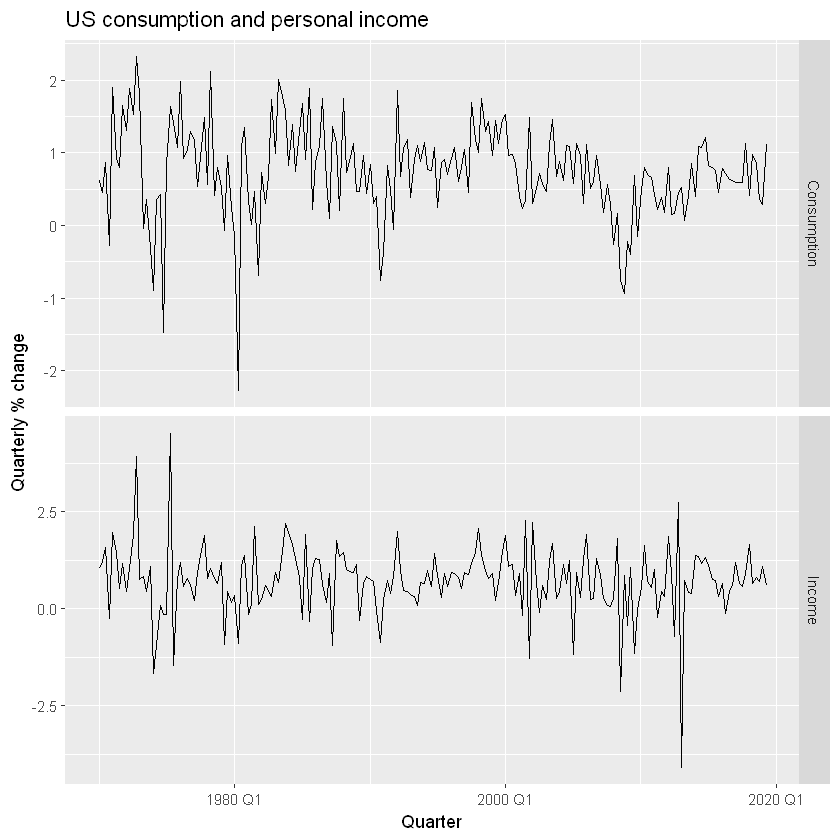

In [3]:
us_change |>
  pivot_longer(c(Consumption, Income),
               names_to = "var", values_to = "value") |>
  ggplot(aes(x = Quarter, y = value)) +
  geom_line() +
  facet_grid(vars(var), scales = "free_y") +
  labs(title = "US consumption and personal income",
       y = "Quarterly % change")

### Vanilla Regression Model

In [4]:
ls_fit <- us_change %>%
    model(TSLM(Consumption ~ Income))

report(ls_fit)

Series: Consumption 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-2.58236 -0.27777  0.01862  0.32330  1.42229 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.54454    0.05403  10.079  < 2e-16 ***
Income       0.27183    0.04673   5.817  2.4e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5905 on 196 degrees of freedom
Multiple R-squared: 0.1472,	Adjusted R-squared: 0.1429
F-statistic: 33.84 on 1 and 196 DF, p-value: 2.4022e-08


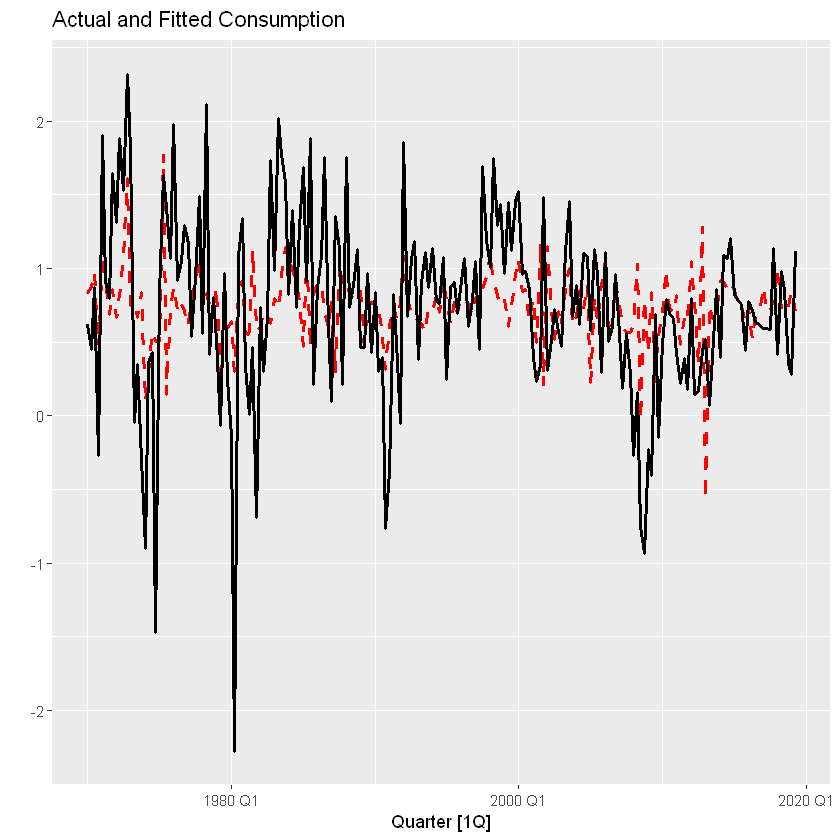

In [5]:
fitted(ls_fit) %>% autoplot(.fitted, colour='red', lty=2, lwd=1) + autolayer(us_change, Consumption, lwd=1) +
labs(title='Actual and Fitted Consumption', y='')

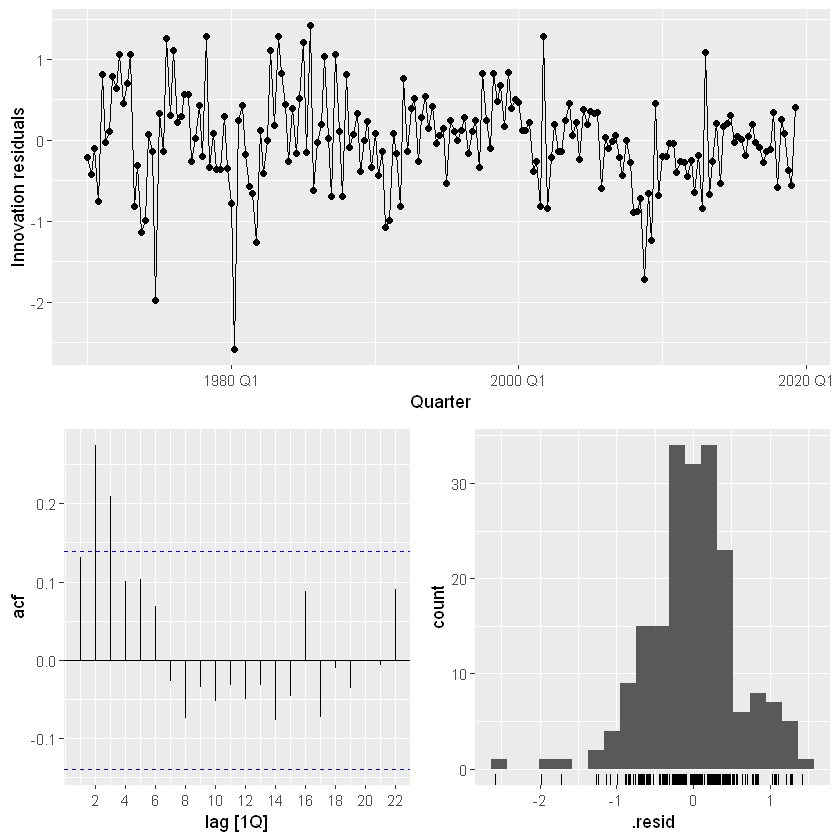

In [6]:
consumption_resid <- ls_fit |> gg_tsresiduals()
consumption_resid

### Model with ARIMA Errors

In [7]:
fit <- us_change |>
  model(ARIMA(Consumption ~ Income))
report(fit)

Series: Consumption 
Model: LM w/ ARIMA(1,0,2) errors 

Coefficients:
         ar1      ma1     ma2  Income  intercept
      0.7070  -0.6172  0.2066  0.1976     0.5949
s.e.  0.1068   0.1218  0.0741  0.0462     0.0850

sigma^2 estimated as 0.3113:  log likelihood=-163.04
AIC=338.07   AICc=338.51   BIC=357.8


$Consumption_t = 0.595 + 0.198Income_t + \eta_t$

$\eta_t = 0.707\eta_{t-1} + \epsilon_t - 0.617\epsilon_{t-1} + 0.207\epsilon_{t-2}$

$\epsilon_t \approx NID(0, 0.311)$

### Residuals
Note the error term in the regression will be $\eta$ and the innnovation is $\epsilon$

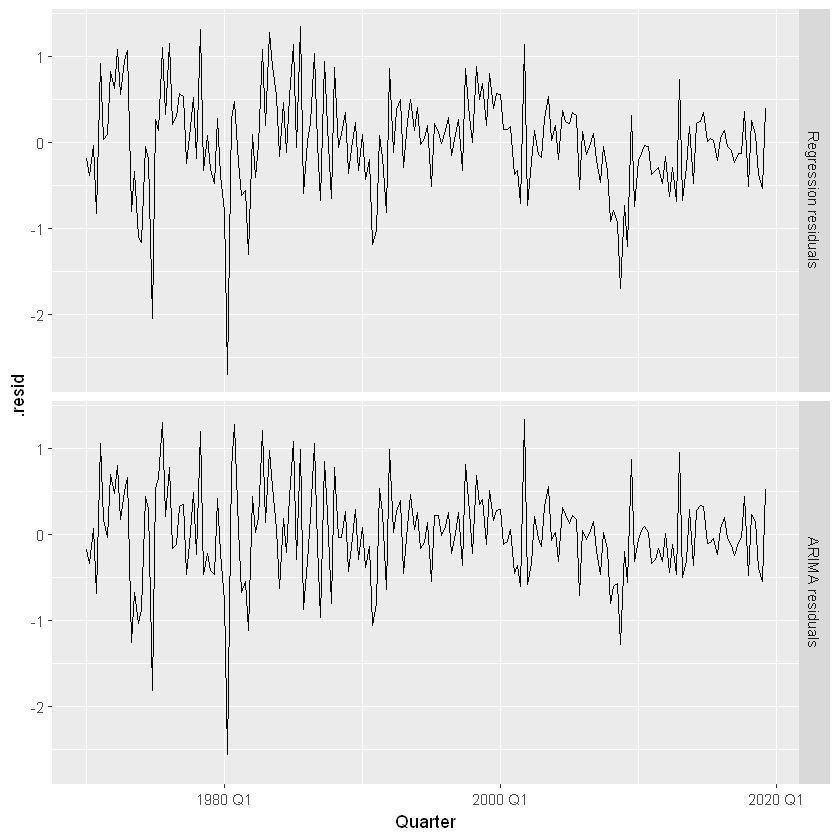

In [8]:
bind_rows(
    `Regression residuals` =
        as_tibble(residuals(fit, type = "regression")),
    `ARIMA residuals` =
        as_tibble(residuals(fit, type = "innovation")),
    .id = "type"
  ) |>
  mutate(
    type = factor(type, levels=c(
      "Regression residuals", "ARIMA residuals"))
  ) |>
  ggplot(aes(x = Quarter, y = .resid)) +
  geom_line() +
  facet_grid(vars(type))

### Residual Analysis of $\epsilon$

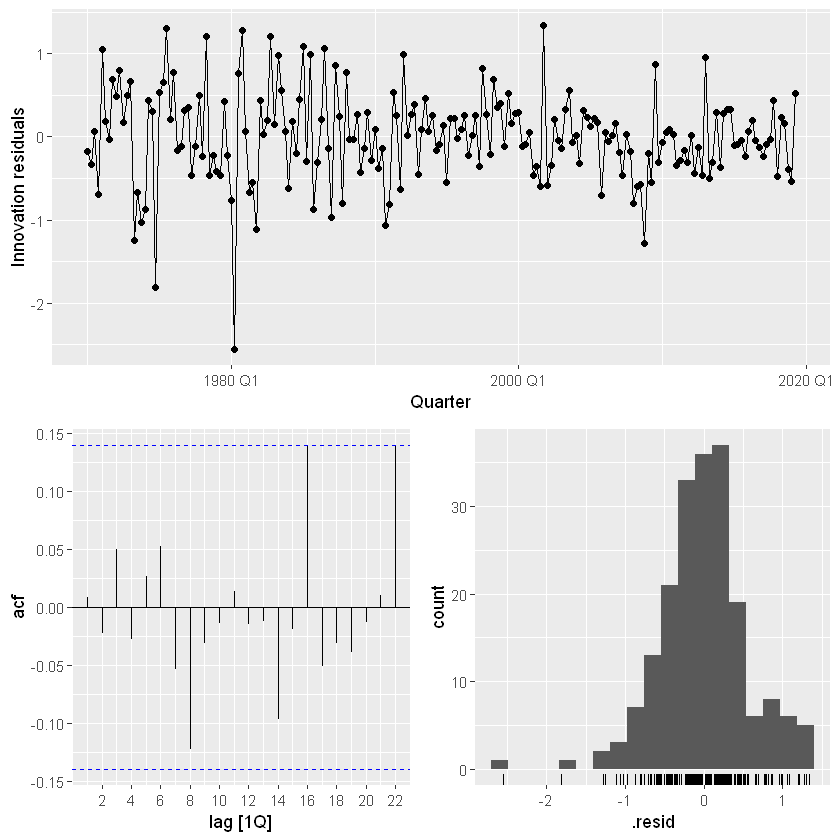

In [9]:
consumption_arma_innovation <- fit |> gg_tsresiduals()

consumption_arma_innovation

In [10]:
augment(fit) |>
  features(.innov, ljung_box, dof = 3, lag = 8)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
ARIMA(Consumption ~ Income),5.207208,0.3911193


### Forecasting
Split the data into training and test sets

In [11]:
us_change_training <-us_change %>% filter_index(. ~ '2015 Q4')
us_change_test <- us_change %>% filter_index('2016 Q1' ~ .)

split_fit <- us_change_training |>
  model(ARIMA(Consumption ~ Income))
report(split_fit)

Series: Consumption 
Model: LM w/ ARIMA(1,0,2) errors 

Coefficients:
         ar1      ma1     ma2  Income  intercept
      0.7041  -0.6099  0.2075  0.2025     0.5950
s.e.  0.1114   0.1267  0.0759  0.0477     0.0901

sigma^2 estimated as 0.3281:  log likelihood=-156.16
AIC=324.31   AICc=324.79   BIC=343.6


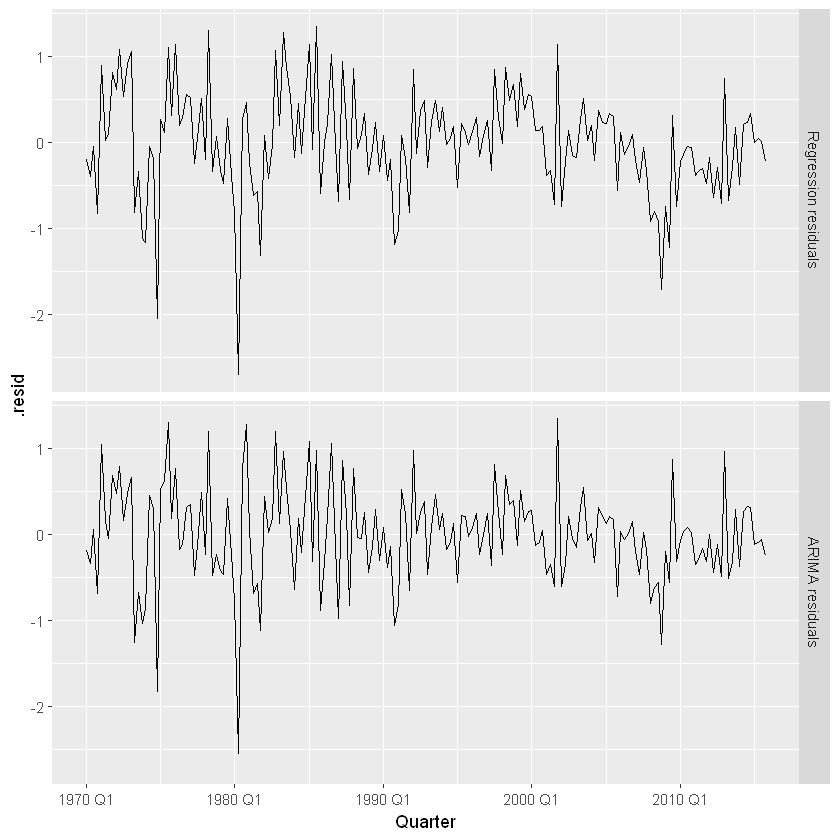

In [12]:
bind_rows(
    `Regression residuals` =
        as_tibble(residuals(split_fit, type = "regression")),
    `ARIMA residuals` =
        as_tibble(residuals(split_fit, type = "innovation")),
    .id = "type"
  ) |>
  mutate(
    type = factor(type, levels=c(
      "Regression residuals", "ARIMA residuals"))
  ) |>
  ggplot(aes(x = Quarter, y = .resid)) +
  geom_line() +
  facet_grid(vars(type))

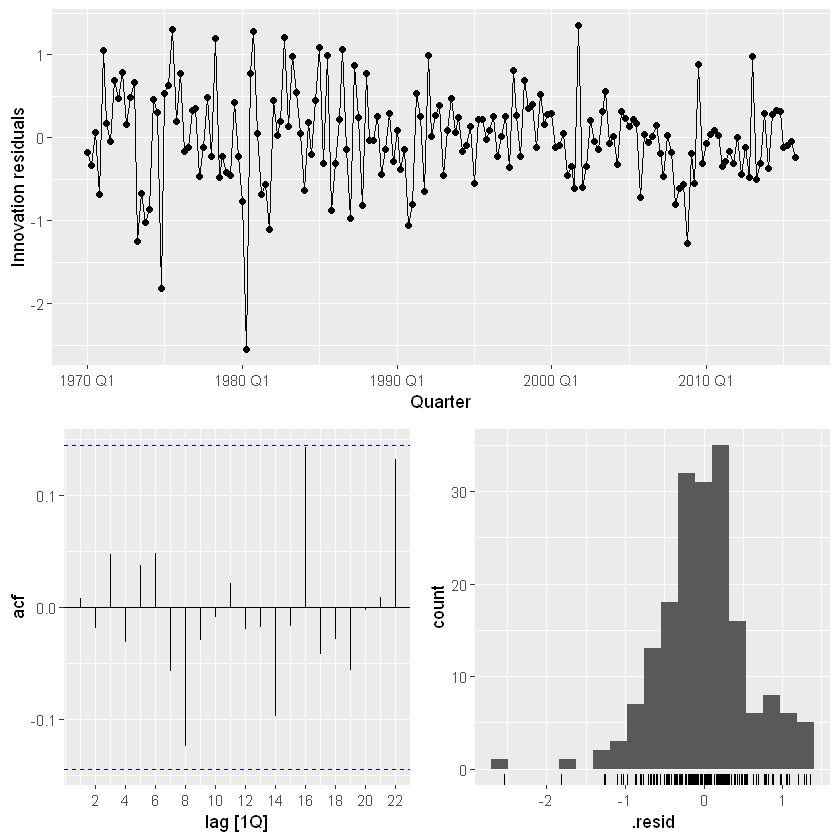

In [13]:
consumption_bad_resid <- split_fit |> gg_tsresiduals()
consumption_bad_resid

In [14]:
split_forecast <- split_fit %>% forecast(us_change_test)

split_forecast %>% accuracy(us_change_test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA(Consumption ~ Income),Test,-0.04099595,0.2905106,0.2386983,-26.06913,46.36815,NaN,NaN,-0.3089214


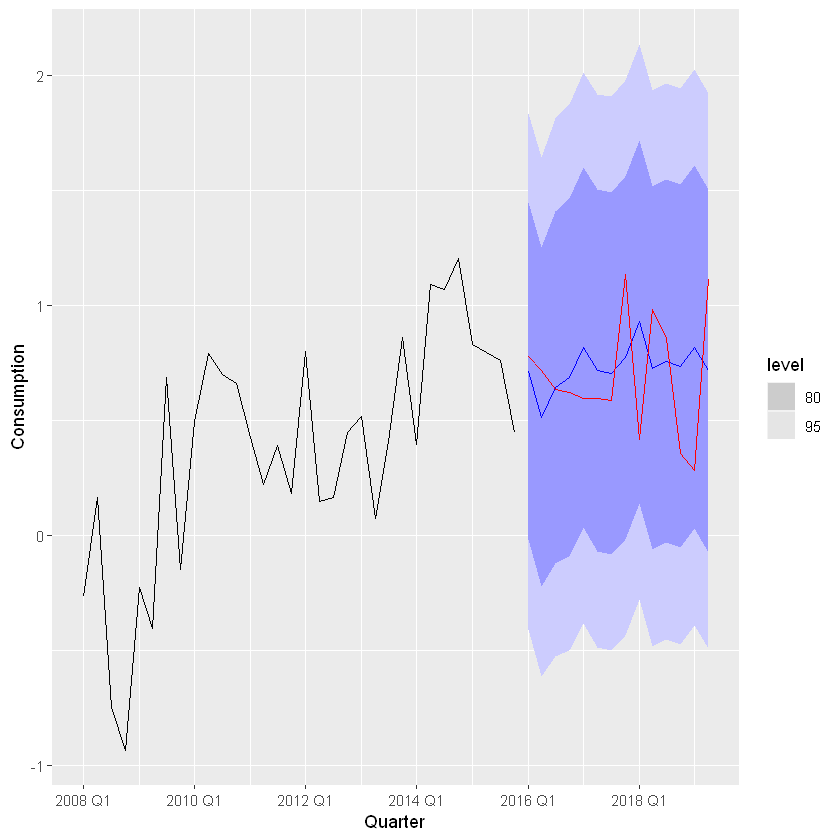

In [15]:
split_forecast %>% autoplot(us_change_training %>% filter_index('2008 Jan' ~ .)) +
autolayer(us_change_test, Consumption, colour='red')

### Using Test Data to Evaulate Accuracy
- The above will be misleading because in reality we wouldn't have access to these values ahead of time.
- We will need to have forecasts of those forecasted values to really evaluate realistic out-of-sample performance.

In [16]:
income_model <- us_change_training %>% model(ARIMA(Income))
report(income_model)

Series: Income 
Model: ARIMA(0,0,2) w/ mean 

Coefficients:
          ma1     ma2  constant
      -0.1335  0.1971    0.7274
s.e.   0.0727  0.0783    0.0708

sigma^2 estimated as 0.832:  log likelihood=-242.7
AIC=493.39   AICc=493.62   BIC=506.25


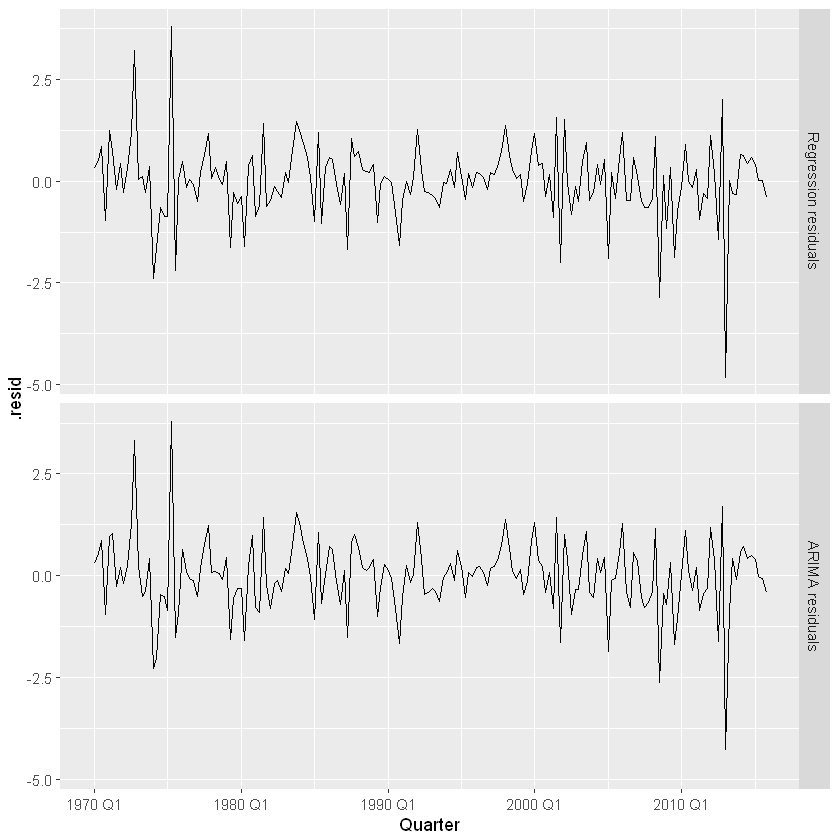

In [17]:
bind_rows(
    `Regression residuals` =
        as_tibble(residuals(income_model, type = "regression")),
    `ARIMA residuals` =
        as_tibble(residuals(income_model, type = "innovation")),
    .id = "type"
  ) |>
  mutate(
    type = factor(type, levels=c(
      "Regression residuals", "ARIMA residuals"))
  ) |>
  ggplot(aes(x = Quarter, y = .resid)) +
  geom_line() +
  facet_grid(vars(type))

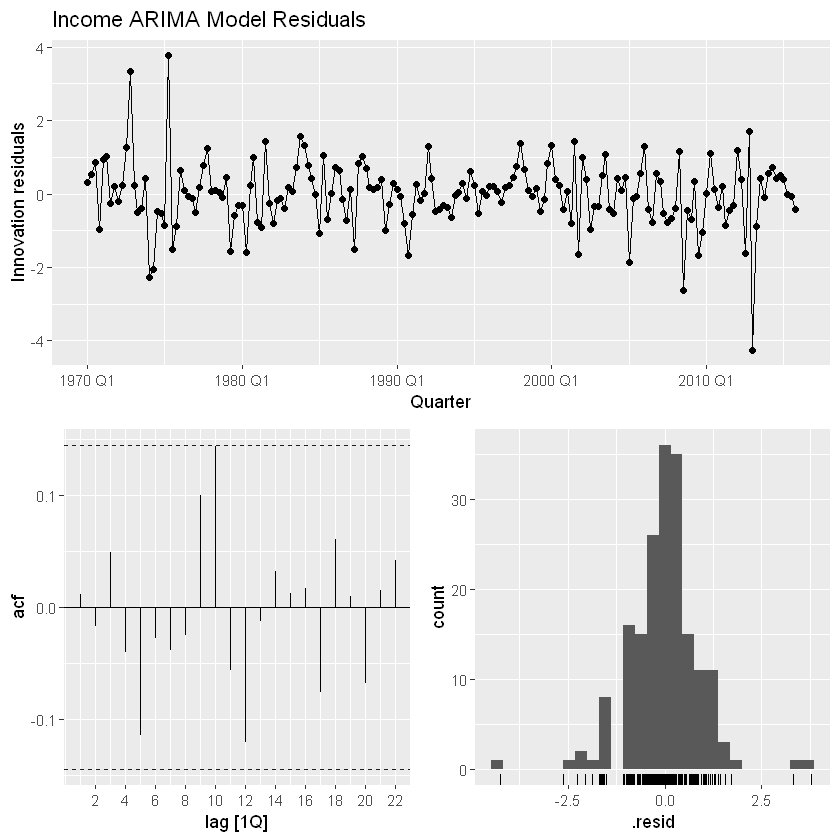

In [18]:
income_resid <- income_model %>% gg_tsresiduals() + labs(title='Income ARIMA Model Residuals')
income_resid

In [19]:
augment(income_model) |>
  features(.innov, ljung_box, dof = 3, lag = 8)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
ARIMA(Income),3.913122,0.561991


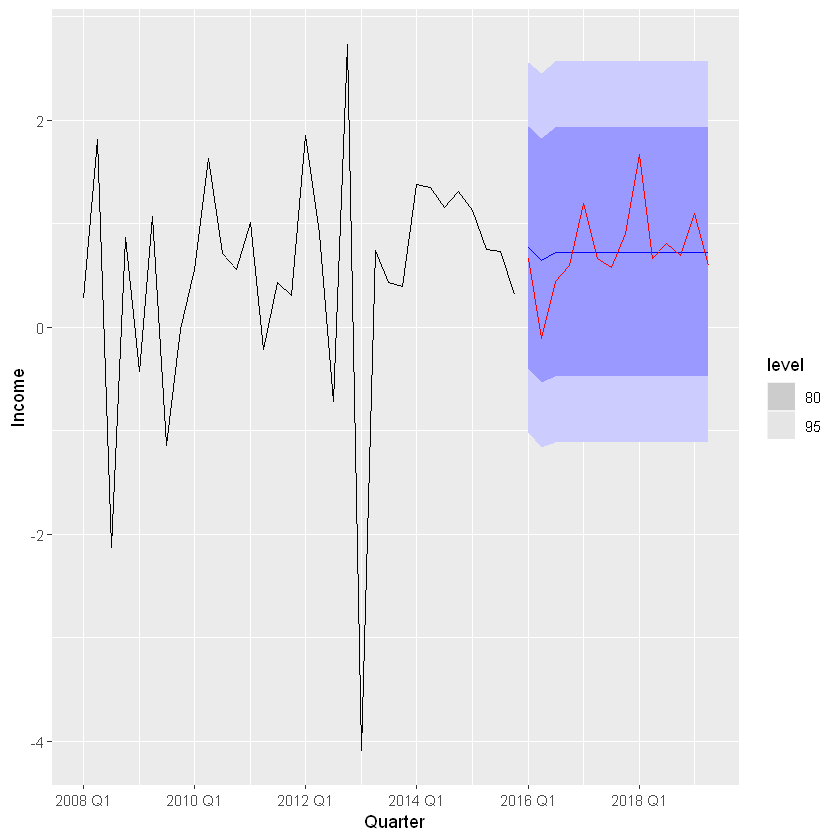

In [20]:
income_forecast <- income_model %>% forecast(us_change_test)

income_forecast %>% autoplot(us_change_training %>% filter_index('2008 Jan' ~ .)) +
autolayer(us_change_test, Income, colour='red')

Notice the forecasts for income will be much smoother than what we would eventually observe in reality.

### Plug in the forecasts for Income into the forecasting model for Consumption

In [21]:
income_plug <- income_forecast %>% select(Quarter, Income, .mean) %>% as_tsibble() %>% select(.mean) %>% rename(Income = .mean) %>% as_tibble() %>% select(-Quarter)
income_plug

Income
<dbl>
0.7681948
0.6454135
0.7273565
0.7273565
0.7273565
0.7273565
0.7273565
0.7273565
0.7273565


In [22]:
us_change_test_new <- us_change_test %>%
    select(-Income) %>%
    bind_cols(income_plug)

us_change_test_new

Quarter,Consumption,Production,Savings,Unemployment,Income
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016 Q1,0.7782543,-0.5189220,-0.07568514,0.0,0.7681948
2016 Q2,0.7155914,-0.5786952,-9.38621669,-0.1,0.6454135
2016 Q3,0.6349156,0.4580707,-2.09617211,0.1,0.7273565
2016 Q4,0.6185453,0.3281454,0.10885389,-0.3,0.7273565
2017 Q1,0.5933365,0.5842729,10.17889613,-0.3,0.7273565
2017 Q2,0.5931534,1.3634526,0.78382422,-0.1,0.7273565
2017 Q3,0.5847379,-0.2011151,0.47774011,-0.1,0.7273565
2017 Q4,1.1331456,1.8121311,-1.32309670,-0.1,0.7273565
2018 Q1,0.4169630,0.5643717,17.41552718,-0.1,0.7273565


In [23]:
split_forecast_new <- split_fit %>% forecast(us_change_test_new)

split_forecast_new %>% accuracy(us_change_test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA(Consumption ~ Income),Test,-0.03622422,0.2539699,0.2109319,-22.97724,40.04234,NaN,NaN,-0.2888733


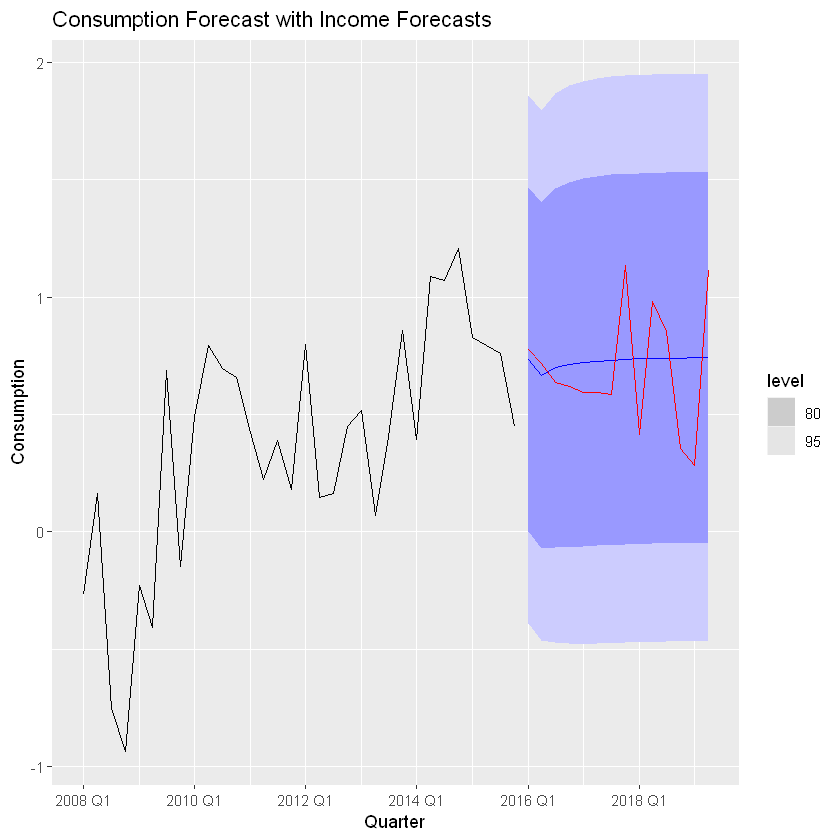

In [24]:
split_forecast_new %>% autoplot(us_change_training %>% filter_index('2008 Jan' ~ .)) +
autolayer(us_change_test, Consumption, colour='red') + labs(title='Consumption Forecast with Income Forecasts')

Note that the above prediction intervals are misleading, as it does not account for the uncertainty in the Income forecasts. In reality, these intervals would be much wider.

Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."
Warning message:
"The output of `fortify(<fable>)` has changed to better suit usage with the ggdist package.
If you're using it to extract intervals, consider using `hilo()` to compute intervals, and `unpack_hilo()` to obtain values."


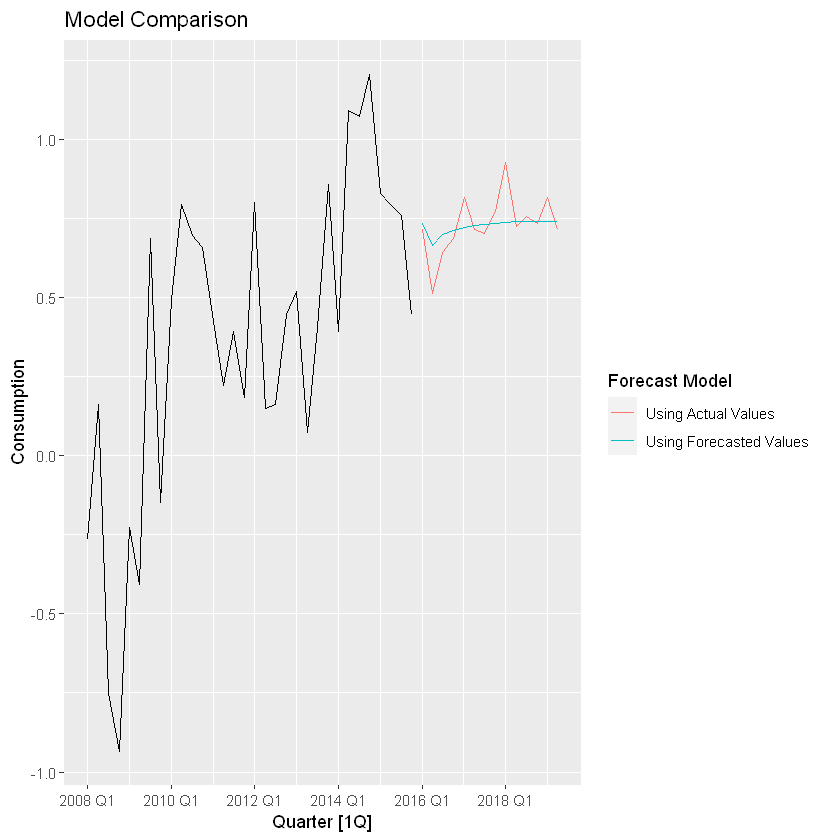

In [25]:
us_change_training %>% filter_index('2008 Q1' ~ .) %>% autoplot(Consumption) +
geom_line(data=split_forecast, aes(x=Quarter, y=.mean, colour='Using Actual Values')) +
geom_line(data=split_forecast_new, aes(x=Quarter, y=.mean, colour='Using Forecasted Values')) +
guides(colour=guide_legend(title='Forecast Model')) + labs(title='Model Comparison')

The assignment will be to look at the uncertainty around using this via simulating the predictions.

### Compare those to ARIMA and ETS

In [26]:
consumption_unidirectional <- us_change_training |>
  model('ARIMA' = ARIMA(Consumption), 'ETS' = ETS(Consumption), 'Mean' = MEAN(Consumption))

consumption_unidirectional

ARIMA,ETS,Mean
<model>,<model>,<model>
"<ARIMA(1,0,3)(1,0,1)[4] w/ mean>","<ETS(A,N,N)>",<MEAN>


In [27]:
consumption_unidirectional %>% accuracy() %>%
select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.5823323,188.6766
ETS,0.6230430,138.0263
Mean,0.6561802,165.4065


In [28]:
consumption_unidirectional_forecasts <- consumption_unidirectional %>%
forecast(us_change_test)

consumption_unidirectional_forecasts %>% accuracy(us_change_test) %>%
select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.2508143,39.41405
ETS,0.2522062,38.06066
Mean,0.2578889,41.56697


### Lagged Predictors with Advertising
This will provide better estimates and won't have the issues with uncertainty around future values.

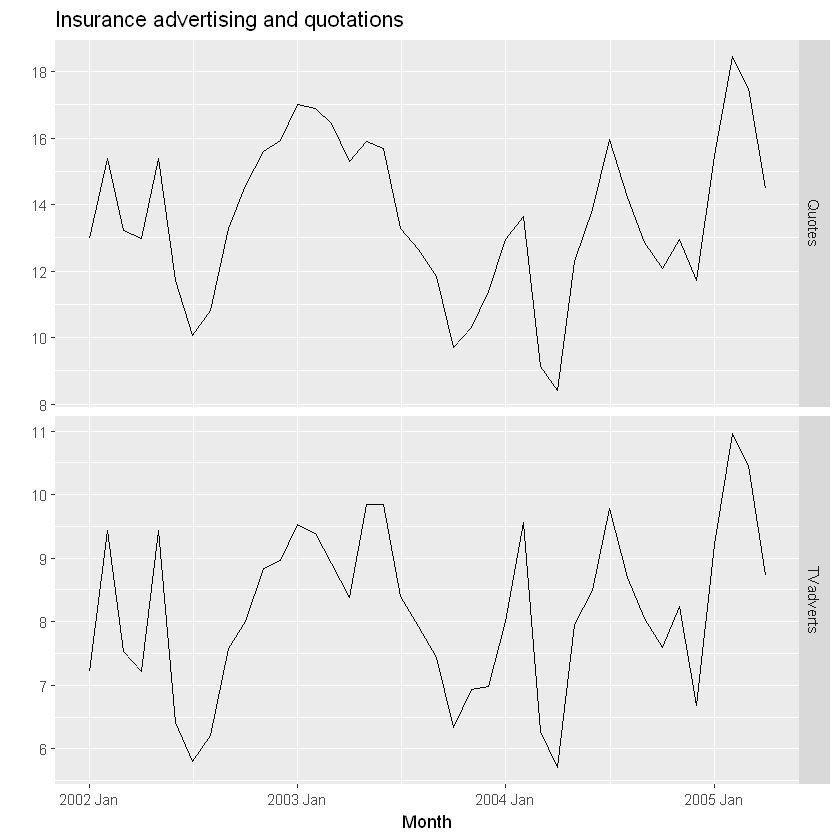

In [29]:
insurance |>
  pivot_longer(Quotes:TVadverts) |>
  ggplot(aes(x = Month, y = value)) +
  geom_line() +
  facet_grid(vars(name), scales = "free_y") +
  labs(y = "", title = "Insurance advertising and quotations")

In [30]:
fit <- insurance |>
  # Restrict data so models use same fitting period
  mutate(Quotes = c(NA, NA, NA, Quotes[4:40])) |>
  # Estimate models
  model(
    lag0 = ARIMA(Quotes ~ pdq(d = 0) + TVadverts),
    lag1 = ARIMA(Quotes ~ pdq(d = 0) +
                 TVadverts + lag(TVadverts)),
    lag2 = ARIMA(Quotes ~ pdq(d = 0) +
                 TVadverts + lag(TVadverts) +
                 lag(TVadverts, 2)),
    lag3 = ARIMA(Quotes ~ pdq(d = 0) +
                 TVadverts + lag(TVadverts) +
                 lag(TVadverts, 2) + lag(TVadverts, 3)),
    lag1_only = ARIMA(Quotes ~ pdq(d = 0) +
                 lag(TVadverts))
  )

In [31]:
glance(fit)

.model,sigma2,log_lik,AIC,AICc,BIC,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<list>
lag0,0.2649757,-28.28210,66.56420,68.32890,75.00859,"1.327251+0.626743i, 1.327251-0.626743i",
lag1,0.2094368,-24.04404,58.08809,59.85279,66.53249,1.488572+0i,-1.489599+0i
lag2,0.2150429,-24.01627,60.03254,62.57799,70.16581,1.49224+0i,-1.479882+0i
lag3,0.2056454,-22.15731,60.31461,64.95977,73.82565,1.321607+0i,-1.647196+0i
lag1_only,2.2368442,-68.14649,146.29297,148.05768,154.73737,,"-1.071815+0.590044i, -1.071815-0.590044i"


In [32]:
fit_best <- insurance |>
  model(ARIMA(Quotes ~ pdq(d = 0) +
              TVadverts + lag(TVadverts)))
report(fit_best)

Series: Quotes 
Model: LM w/ ARIMA(1,0,2) errors 

Coefficients:
         ar1     ma1     ma2  TVadverts  lag(TVadverts)  intercept
      0.5123  0.9169  0.4591     1.2527          0.1464     2.1554
s.e.  0.1849  0.2051  0.1895     0.0588          0.0531     0.8595

sigma^2 estimated as 0.2166:  log likelihood=-23.94
AIC=61.88   AICc=65.38   BIC=73.7


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


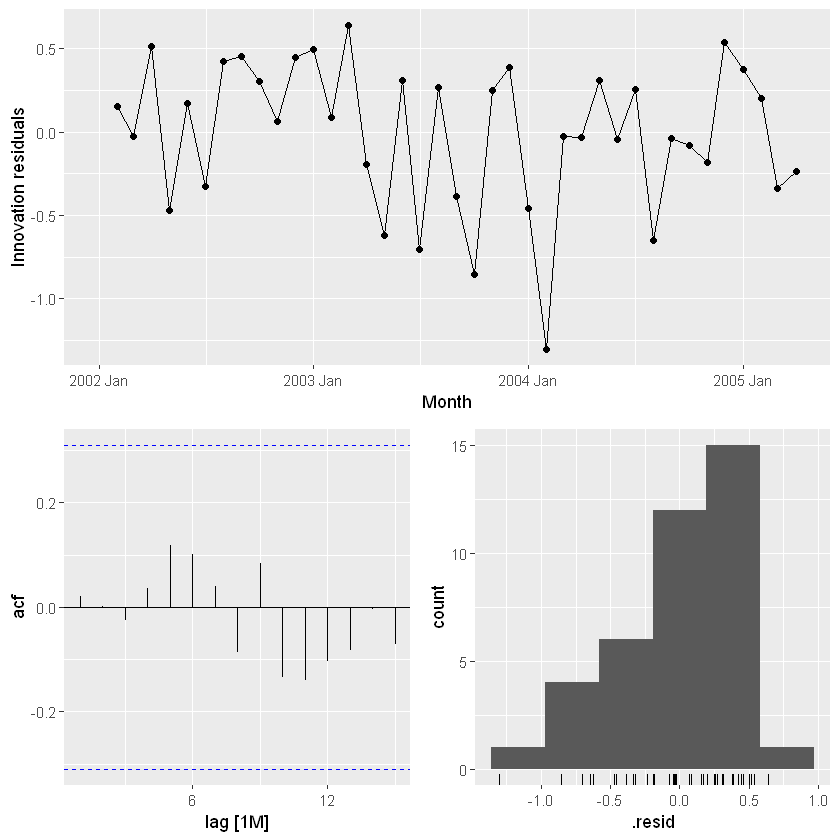

In [33]:
ad_resid <- fit_best %>% gg_tsresiduals()
ad_resid

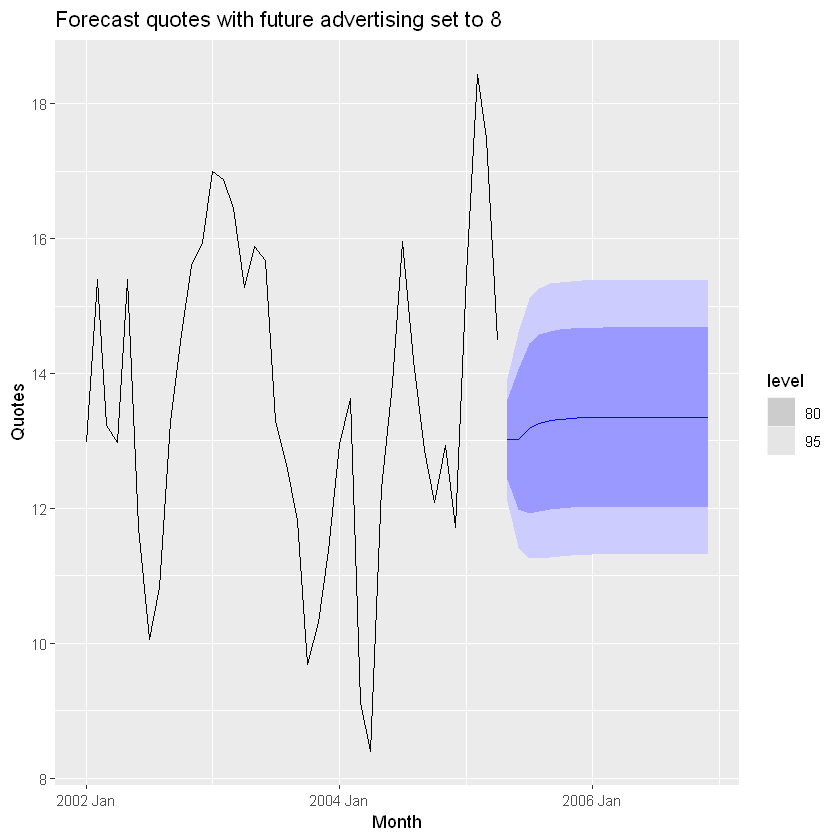

In [34]:
insurance_future <- new_data(insurance, 20) |>
  mutate(TVadverts = 8)
fit_best |>
  forecast(insurance_future) |>
  autoplot(insurance) +
  labs(
    y = "Quotes",
    title = "Forecast quotes with future advertising set to 8"
  )

### Harmonic Regression with Gasoline

In [35]:
us_gasoline %>% head()

Week,Barrels
<week>,<dbl>
1991 W06,6.621
1991 W07,6.433
1991 W08,6.582
1991 W09,7.224
1991 W10,6.875
1991 W11,6.947


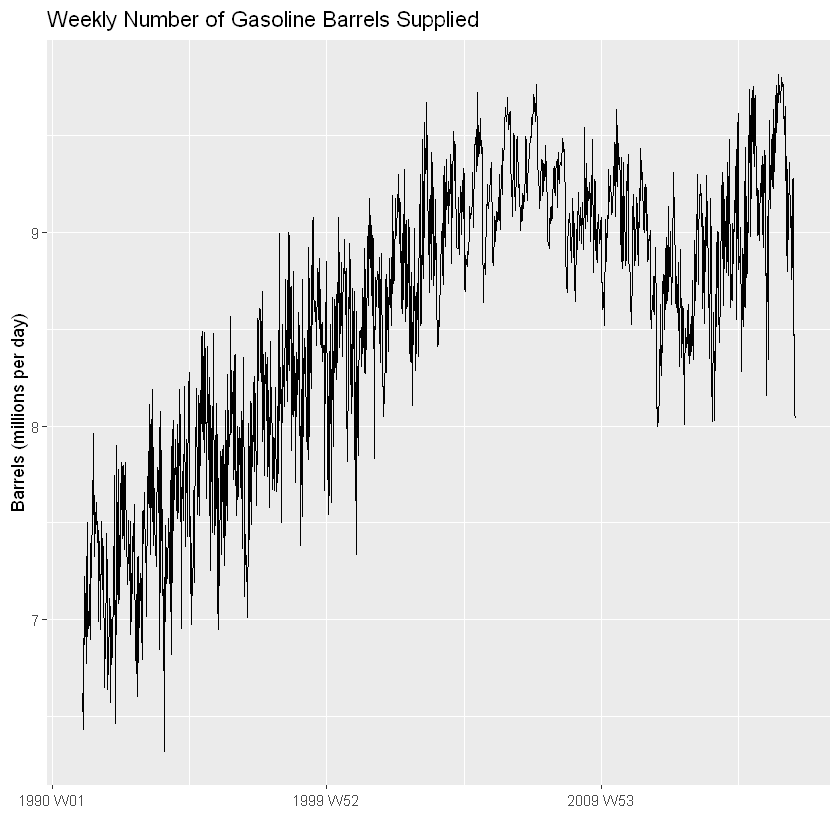

In [36]:
us_gasoline %>% 
autoplot(Barrels) +
labs(title='Weekly Number of Gasoline Barrels Supplied', x='', y='Barrels (millions per day)')

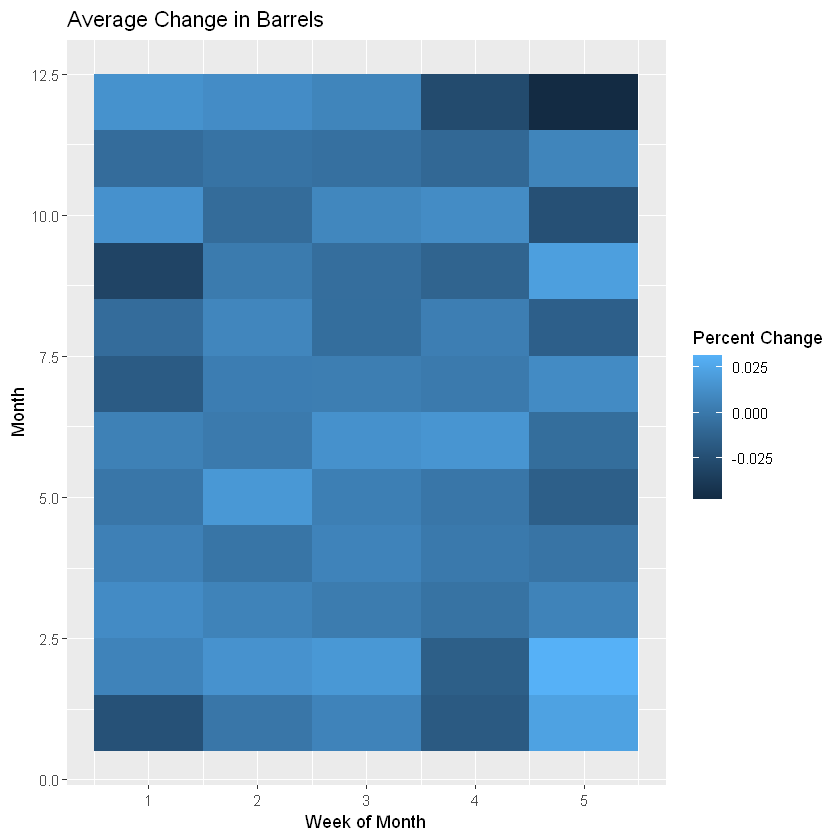

In [37]:
us_gasoline %>%
mutate(year_nbr = year(Week), month_nbr = month(Week), week_nbr = week(Week), BarrelsChg = difference(log(Barrels))) %>%
filter(!is.na(BarrelsChg)) %>%
as_tibble() %>%
arrange(month_nbr, week_nbr) %>%
group_by(year_nbr, month_nbr) %>%
mutate(week_month = row_number()) %>%
ungroup() %>%
group_by(month_nbr, week_month) %>%
summarise(`Percent Change` = mean(BarrelsChg), .groups='drop') %>%
ggplot() +
geom_tile(aes(x=week_month, y=month_nbr, fill=`Percent Change`)) +
labs(x='Week of Month',y='Month', title='Average Change in Barrels')

In [38]:
gas_tr <- us_gasoline %>% filter_index(. ~ '2014 W52')
gas_ts <- us_gasoline %>% filter_index('2015 W1' ~ .)

In [39]:
fit <- gas_tr |>
model(
    'ARIMA' = ARIMA(Barrels),
    'Dummies' = ARIMA(Barrels ~ season() + PDQ(0,0,0)),
    'K06' = ARIMA(Barrels ~ fourier(K = 6) + PDQ(0,0,0))
)

fit %>% report() %>% select(.model, AIC, AICc)

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,AIC,AICc
<chr>,<dbl>,<dbl>
ARIMA,237.42273,237.45496
Dummies,86.74966,91.73706
K06,60.98487,61.37511


In [40]:
fit %>% accuracy() %>% select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.2646783,2.464362
Dummies,0.2396607,2.243077
K06,0.2447333,2.288238


Plot variable not specified, automatically selected `.vars = .fitted`


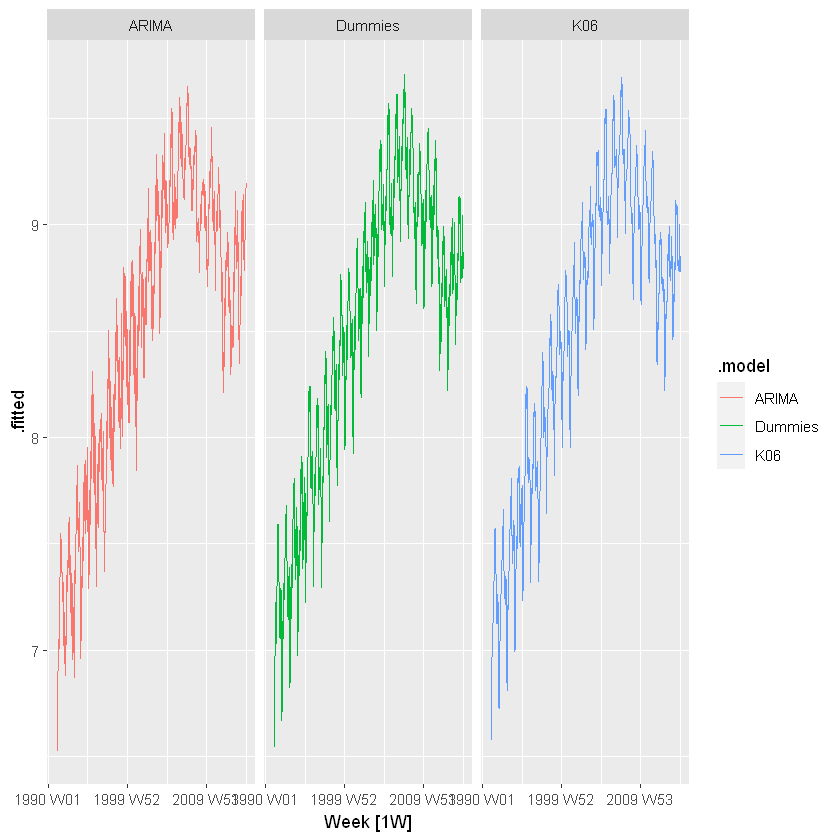

In [41]:
fit %>% fitted() %>% autoplot() + facet_wrap(. ~ .model)

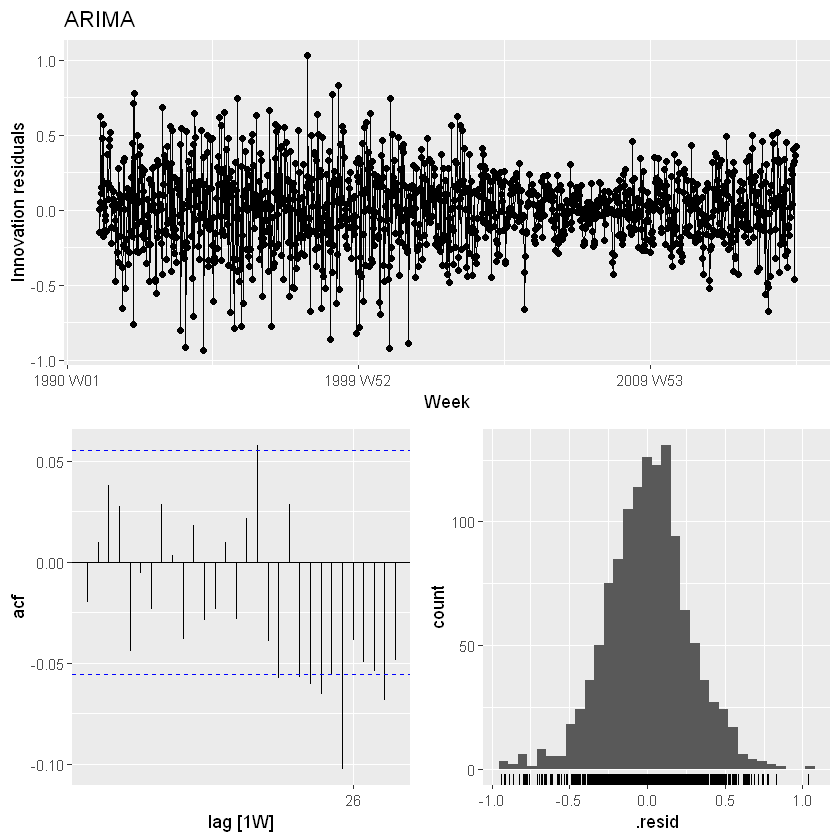

In [42]:
fit %>% select('ARIMA') %>% gg_tsresiduals() + labs(title = 'ARIMA')

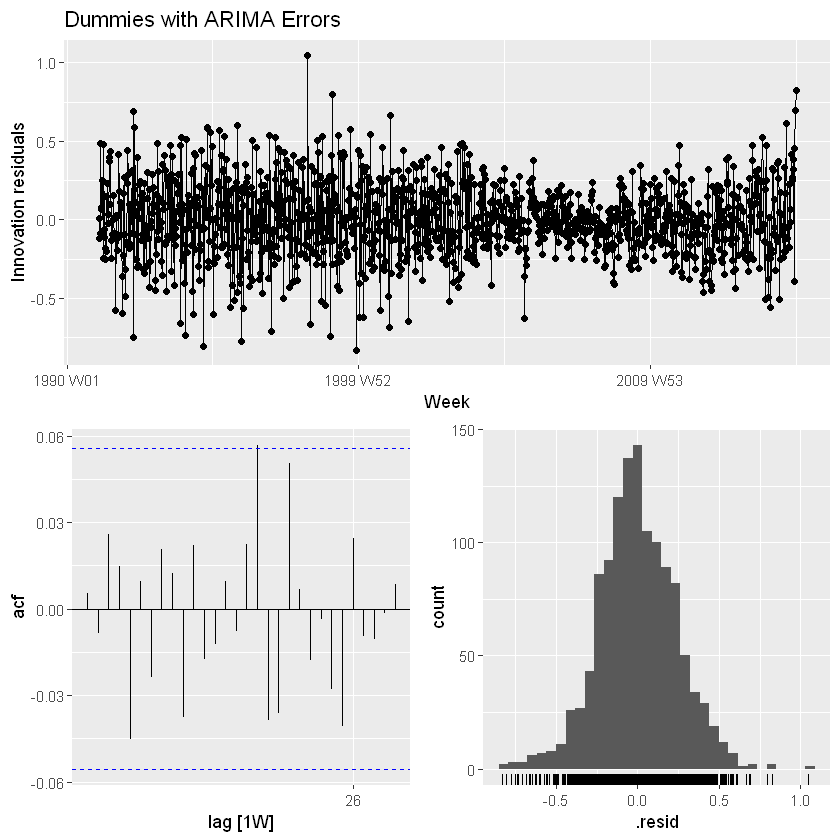

In [43]:
fit %>% select('Dummies') %>% gg_tsresiduals() + labs(title = 'Dummies with ARIMA Errors')

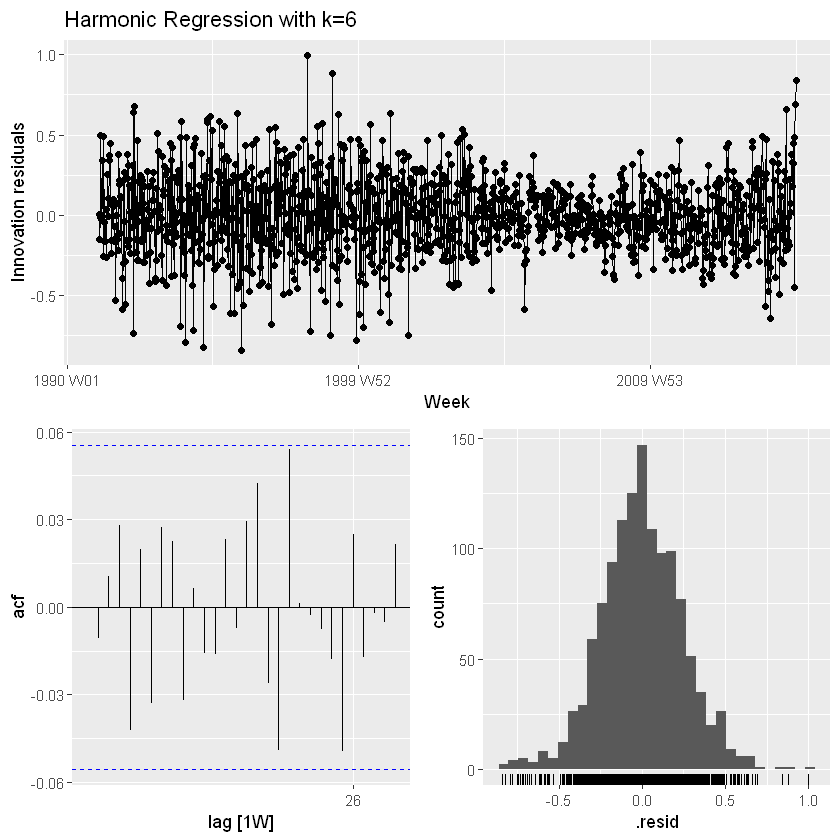

In [44]:
fit %>% select('K06') %>% gg_tsresiduals() + labs(title = 'Harmonic Regression with k=6')

In [45]:
gas_forecast <- fit %>% forecast(gas_ts)

gas_forecast %>% accuracy(gas_ts) %>% select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.4295808,3.672159
Dummies,0.3070323,2.727976
K06,0.2994522,2.677214


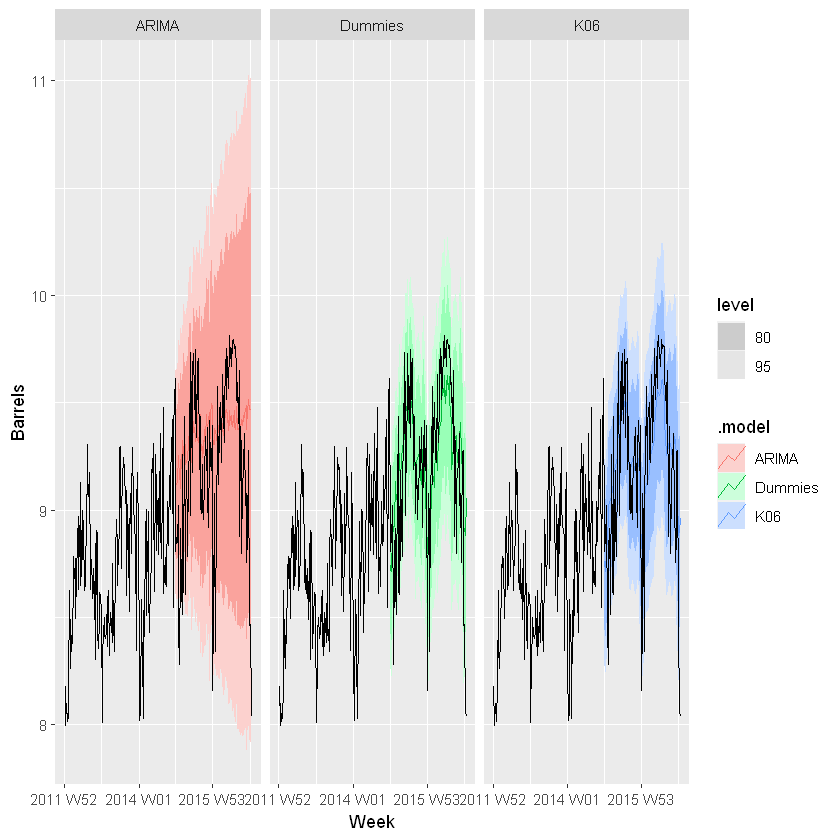

In [46]:
gas_forecast |>
autoplot(us_gasoline %>% filter_index('2012 W1' ~ .)) +
facet_wrap(. ~ .model)

### Calender Effects with Electricity Demand

In [47]:
vic_elec %>% head()

Time,Demand,Temperature,Date,Holiday
<dttm>,<dbl>,<dbl>,<date>,<lgl>
2012-01-01 00:00:00,4382.825,21.40,2012-01-01,TRUE
2012-01-01 00:30:00,4263.366,21.05,2012-01-01,TRUE
2012-01-01 01:00:00,4048.966,20.70,2012-01-01,TRUE
2012-01-01 01:30:00,3877.563,20.55,2012-01-01,TRUE
2012-01-01 02:00:00,4036.230,20.40,2012-01-01,TRUE
2012-01-01 02:30:00,3865.597,20.25,2012-01-01,TRUE


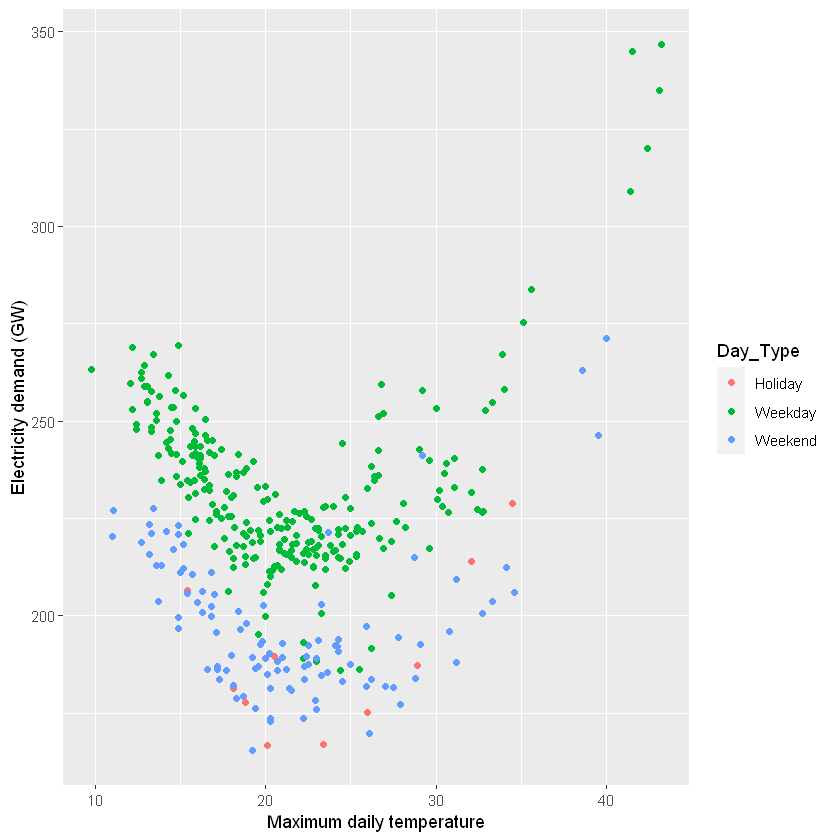

In [48]:
vic_elec_daily <- vic_elec |>
  filter(year(Time) == 2014) |>
  index_by(Date = date(Time)) |>
  summarise(
    Demand = sum(Demand) / 1e3,
    Temperature = max(Temperature),
    Holiday = any(Holiday)
  ) |>
  mutate(Day_Type = case_when(
    Holiday ~ "Holiday",
    wday(Date) %in% 2:6 ~ "Weekday",
    TRUE ~ "Weekend"
  ))

vic_elec_daily |>
  ggplot(aes(x = Temperature, y = Demand, colour = Day_Type)) +
  geom_point() +
  labs(y = "Electricity demand (GW)",
       x = "Maximum daily temperature")

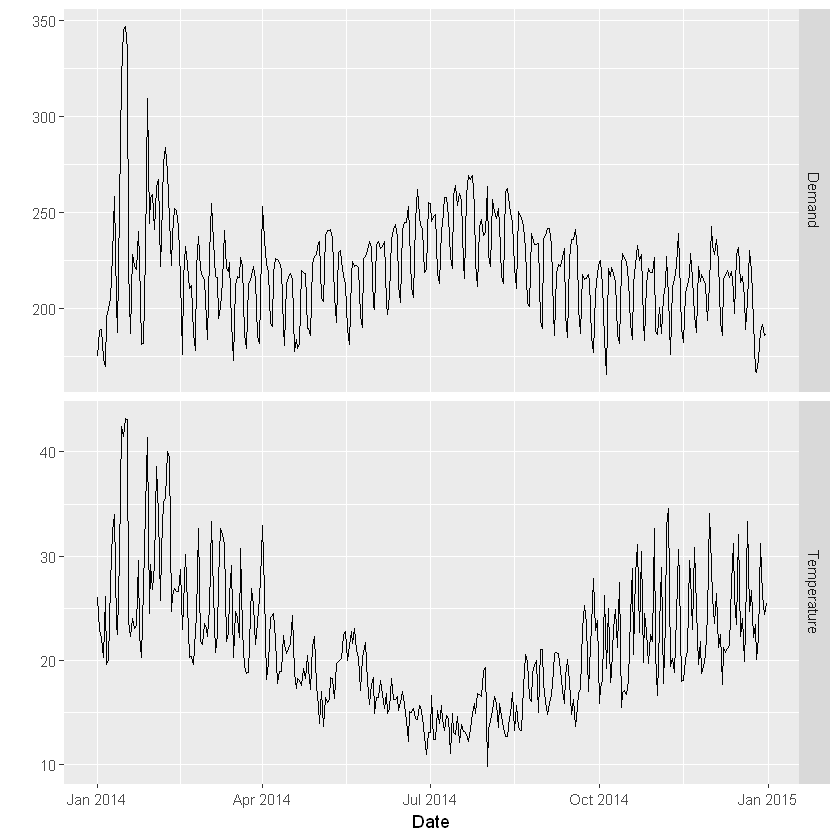

In [49]:
vic_elec_daily |>
  pivot_longer(c(Demand, Temperature)) |>
  ggplot(aes(x = Date, y = value)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") + ylab("")

In [50]:
vfit <- vic_elec_daily |>
  model(quad = ARIMA(Demand ~ Temperature + I(Temperature^2) +
                (Day_Type == "Weekday")),
        linear = ARIMA(Demand ~ Temperature +
                (Day_Type == "Weekday"))
        )

glance(vfit) %>% select(-ar_roots)

.model,sigma2,log_lik,AIC,AICc,BIC,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>
quad,44.90571,-1206.106,2432.212,2432.835,2471.184,"1.022812+0i, -1.042261+0i"
linear,107.06234,-1362.881,2745.762,2746.386,2784.734,1.065384+0i


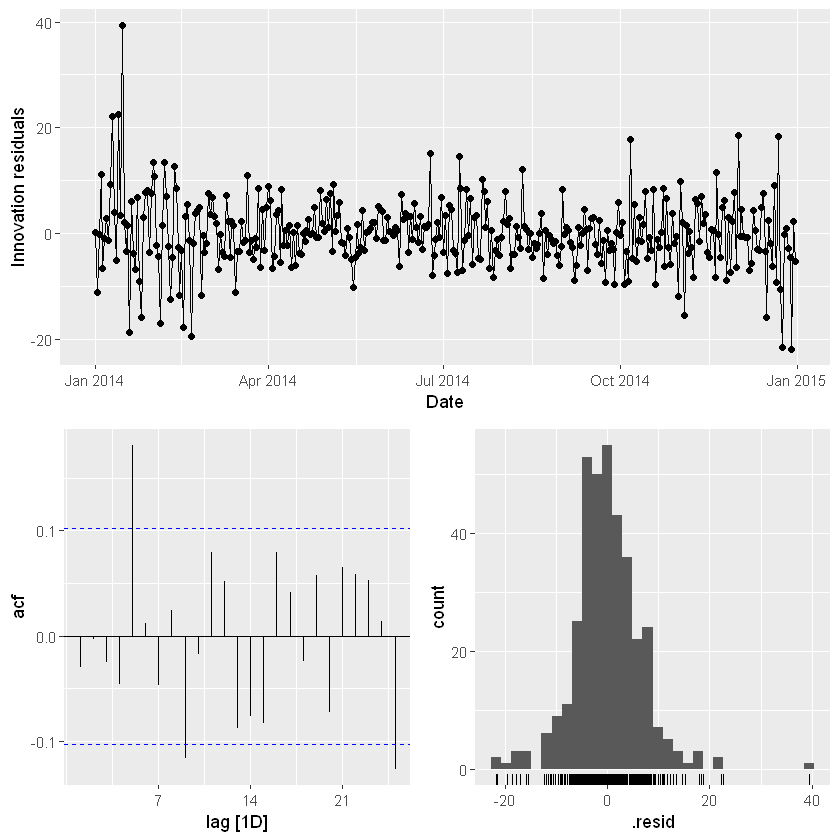

In [51]:
vfit <- vic_elec_daily |>
  model(ARIMA(Demand ~ Temperature + I(Temperature^2) +
                (Day_Type == "Weekday")))
                
electricity_residuals <- vfit |> gg_tsresiduals()
electricity_residuals

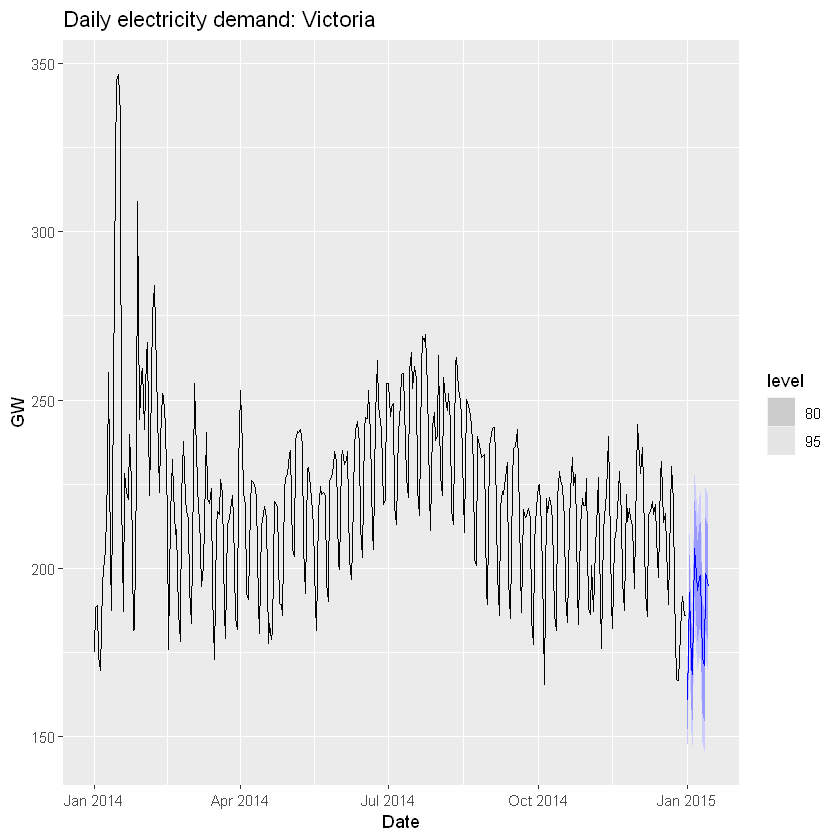

In [52]:
vic_elec_future <- new_data(vic_elec_daily, 14) |>
  mutate(
    Temperature = 26,
    Holiday = c(TRUE, rep(FALSE, 13)),
    Day_Type = case_when(
      Holiday ~ "Holiday",
      wday(Date) %in% 2:6 ~ "Weekday",
      TRUE ~ "Weekend"
    )
  )

forecast(vfit, vic_elec_future) |>
  autoplot(vic_elec_daily) +
  labs(title="Daily electricity demand: Victoria",
       y="GW")

### Trend with Air Passengers

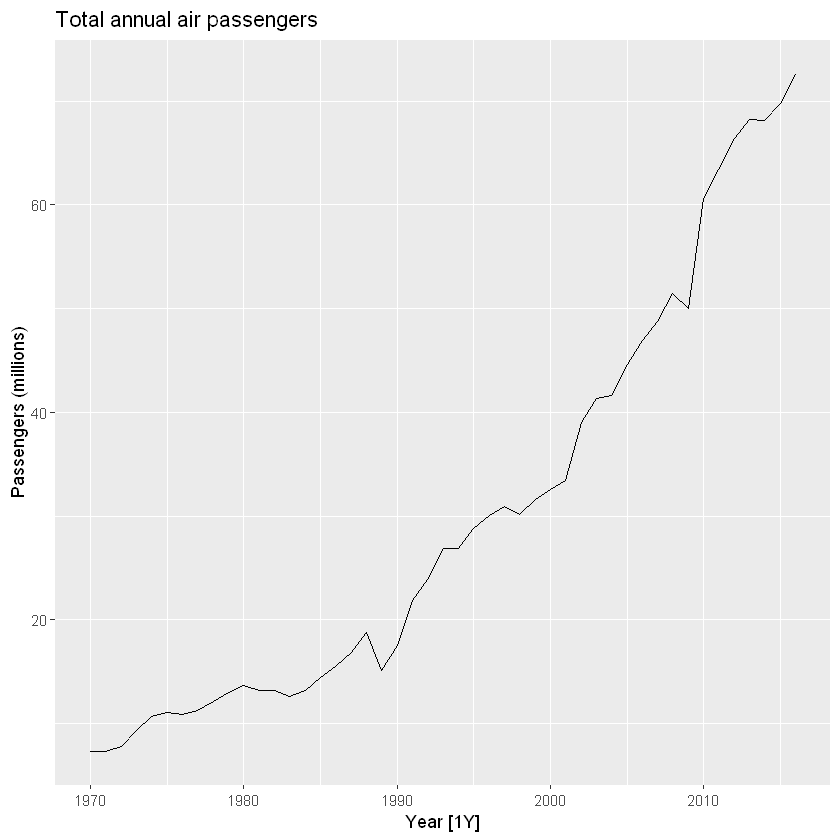

In [53]:
aus_airpassengers |>
  autoplot(Passengers) +
  labs(y = "Passengers (millions)",
       title = "Total annual air passengers")

In [54]:
fit_deterministic <- aus_airpassengers |>
  model(deterministic = ARIMA(Passengers ~ 1 + trend() +
                                pdq(d = 0)))
report(fit_deterministic)

Series: Passengers 
Model: LM w/ ARIMA(1,0,0) errors 

Coefficients:
         ar1  trend()  intercept
      0.9564   1.4151     0.9014
s.e.  0.0362   0.1972     7.0751

sigma^2 estimated as 4.343:  log likelihood=-100.88
AIC=209.77   AICc=210.72   BIC=217.17


In [55]:
fit_stochastic <- aus_airpassengers |>
  model(stochastic = ARIMA(Passengers ~ pdq(d = 1)))
report(fit_stochastic)

Series: Passengers 
Model: ARIMA(0,1,0) w/ drift 

Coefficients:
      constant
        1.4191
s.e.    0.3014

sigma^2 estimated as 4.271:  log likelihood=-98.16
AIC=200.31   AICc=200.59   BIC=203.97


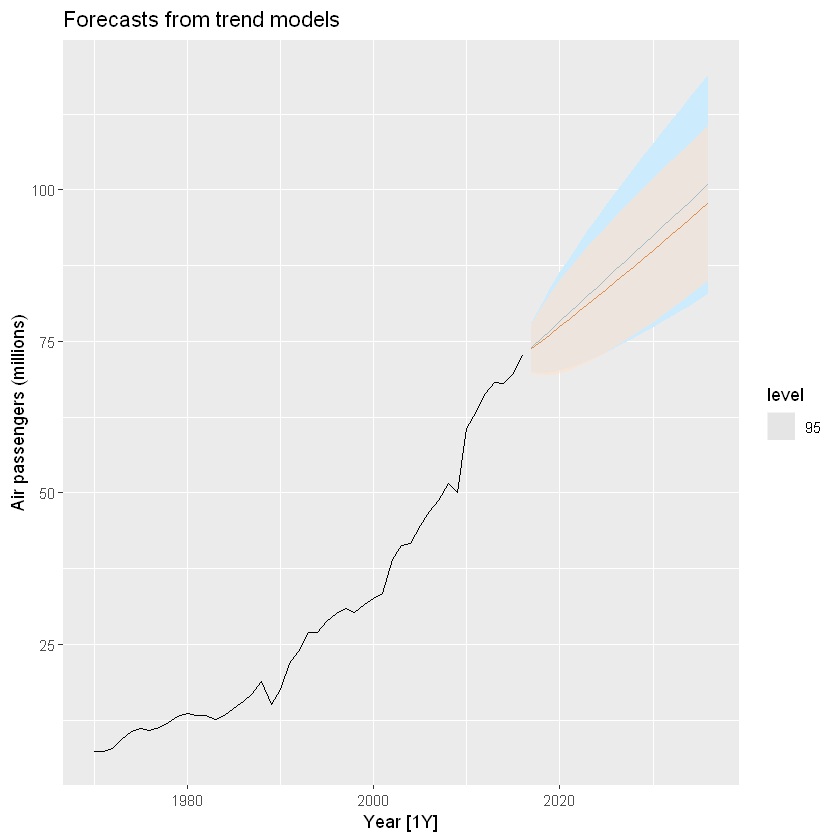

In [56]:
aus_airpassengers |>
  autoplot(Passengers) +
  autolayer(fit_stochastic |> forecast(h = 20),
    colour = "#0072B2", level = 95) +
  autolayer(fit_deterministic |> forecast(h = 20),
    colour = "#D55E00", alpha = 0.65, level = 95) +
  labs(y = "Air passengers (millions)",
       title = "Forecasts from trend models")

### Trend

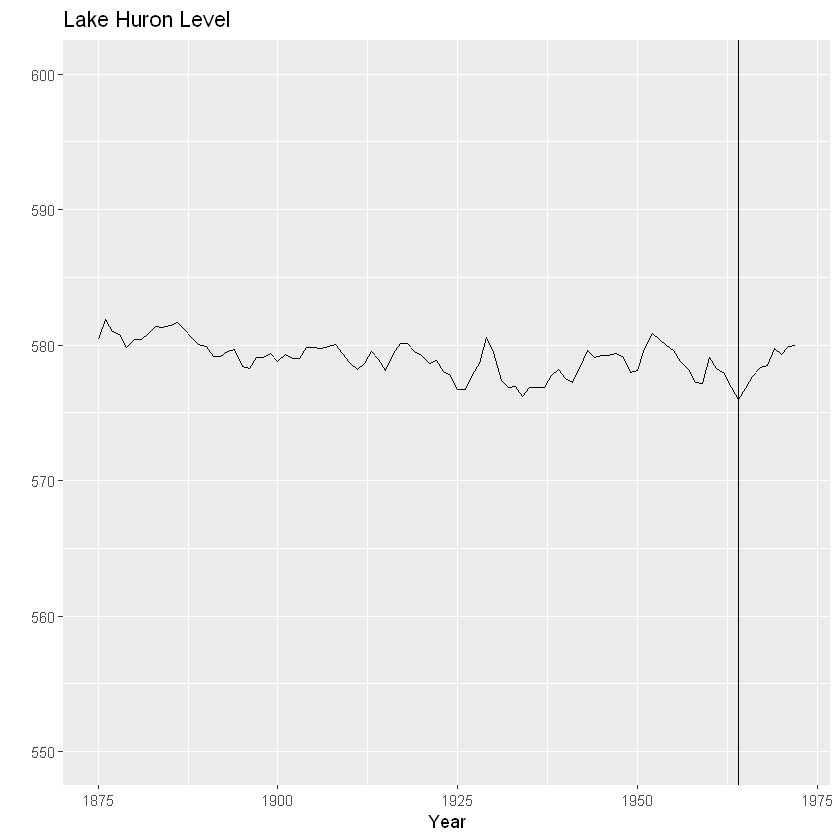

In [57]:
lake <- LakeHuron %>% as_tsibble()

lake %>% autoplot(value) + labs(title='Lake Huron Level', x='Year', y='') + 
ylim(550,600) + geom_vline(xintercept = 1964)

Plot variable not specified, automatically selected `.vars = value`


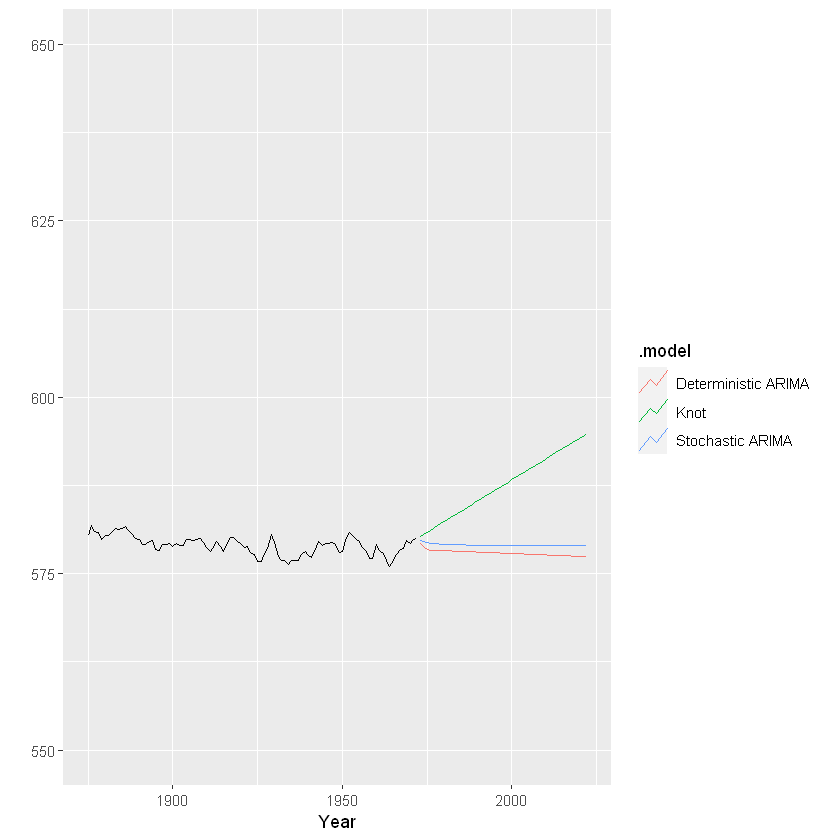

In [58]:
lake %>% 
model(
    'Deterministic ARIMA' = ARIMA(value ~ trend() + pdq(d = 1)),
    'Stochastic ARIMA' = ARIMA(value ~ pdq(d = 0)),
    'Knot' = TSLM(value ~ trend(knots=c(1964)))
) %>% forecast(h='50 years') %>% autoplot(level=NULL) + autolayer(lake) + ylim(550, 650) +
labs(y='', x='Year')